#### Prepared for Gabor's Data Analysis

# Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

# Chapter 17

Data preparation

In [1]:
import os
import pandas as pd
import numpy as np
import sys
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Import the prewritten helper functions
from py_helper_functions import *

# Import data

## 1. clean train data

In [3]:
data = pd.read_csv("../data/raw/cs_bisnode_panel.csv")
data = data.query('year <=2012 & year >= 2010')
data = data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages'])


# Label engineering


In [4]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [5]:
data_raw = data.copy()

### drop those, who went bankrupt in 2010 or 2011

In [6]:
data = data_raw.copy()

In [7]:
data = data.assign(
    year=lambda x: x["year"].astype(str),
    lived_at_the_end_of_the_year=lambda x: x["year"] + "-12-31",
)

In [8]:
data.comp_id.nunique()

33359

In [9]:
has_no_begin_in_2010_or_2011 = (
    data.loc[
        lambda x: (x["year"].isin(["2010", "2011"]) & x["begin"].isnull()), "comp_id"
    ]
    .drop_duplicates()
    .tolist()
)

In [10]:
data = data.loc[lambda x: ~x["comp_id"].isin(has_no_begin_in_2010_or_2011)]

In [11]:
data.comp_id.nunique()

24188

In [12]:
died_in_2010 = data.loc[
    lambda x: ((x["year"] == "2010") & (x["end"] < x["lived_at_the_end_of_the_year"])),
    "comp_id",
].tolist()

died_in_2011 = data.loc[
    lambda x: ((x["year"] == "2011") & (x["end"] < x["lived_at_the_end_of_the_year"])),
    "comp_id",
].tolist()

dropping them here

In [13]:
data = data.loc[lambda x: ~x["comp_id"].isin(died_in_2011 + died_in_2010)]

## drop those who's status is not alive in 2010 or 2011

In [14]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

In [15]:
data["status_alive"].value_counts()

1    58583
0    12955
Name: status_alive, dtype: int64

In [16]:
status_dead_2010 = data.loc[lambda x: (x["status_alive"] == 0) & (x["year"] == "2010"),"comp_id"].tolist()
status_dead_2011 = data.loc[lambda x: (x["status_alive"] == 0) & (x["year"] == "2011"),"comp_id"].tolist()

In [17]:
data = data.loc[lambda x: ~x["comp_id"].isin(status_dead_2010 + status_dead_2011)]

In [18]:
data.comp_id.nunique()

19147

In [19]:
data["sales"].describe()

count    5.612900e+04
mean     5.753157e+05
std      4.128342e+06
min     -1.834445e+04
25%      1.500000e+04
50%      4.639259e+04
75%      1.447148e+05
max      1.110294e+08
Name: sales, dtype: float64

In [20]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log


<AxesSubplot:>

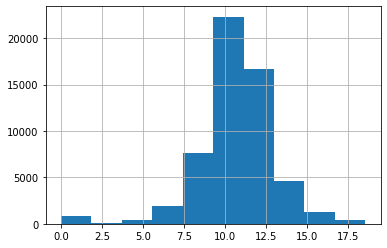

In [21]:
data.ln_sales.hist()

In [22]:
data = data.sort_values(by=["comp_id","year"])

In [23]:
data["sale_growth"] = data["ln_sales"] - data.groupby("comp_id")["ln_sales"].shift(1)

In [24]:
vars = ["comp_id","year","status_alive","sales","ln_sales","sale_growth"]

In [25]:
data[vars].head(20)

,comp_id,year,status_alive,sales,ln_sales,sale_growth
2,1002029.0,2010,1,8.437741e+05,13.645640,NaN
33361,1002029.0,2011,1,5.732222e+05,13.259029,-0.386611
66720,1002029.0,2012,1,1.136515e+06,13.943477,0.684448
3,1003200.0,2010,1,1.379259e+04,9.531887,NaN
33362,1003200.0,2011,1,1.157778e+04,9.356843,-0.175044
66721,1003200.0,2012,1,2.785185e+03,7.932070,-1.424773
4,1004012.0,2010,1,2.533333e+03,7.837291,NaN
33363,1004012.0,2011,1,1.914815e+03,7.557376,-0.279915
66722,1004012.0,2012,0,NaN,NaN,NaN
5,1007261.0,2010,1,2.188889e+03,7.691149,NaN


<AxesSubplot:>

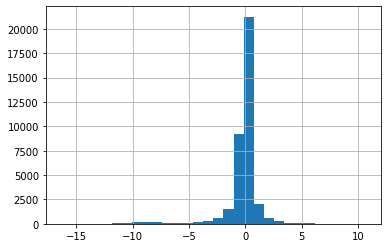

In [26]:
data.sale_growth.hist(bins=30)

In [27]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"].astype(int) - data["founded_year"] < 0, 0, data["year"].astype(int) - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["sale_growth"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["sale_growth"])
)
data["new"] = np.where(data["sale_growth"].isna(), 1, data["new"])
data["sale_growth"] = np.where(data["sale_growth"].isna(), 0, data["sale_growth"])

In [28]:
data['sale_growth'].describe()

count    57441.000000
mean        -0.146176
std          1.161675
min        -16.260223
25%         -0.049354
50%          0.000000
75%          0.018978
max         10.658247
Name: sale_growth, dtype: float64

In [29]:
data['new'].describe()

count    57441.000000
mean         0.444090
std          0.496869
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: new, dtype: float64

In [30]:
data.to_csv("../data/clean/data_train_raw.csv",index=False)

## target variable

target variable will be next year's growth

In [31]:
data = pd.read_csv("../data/clean/data_train_raw.csv")

<AxesSubplot:>

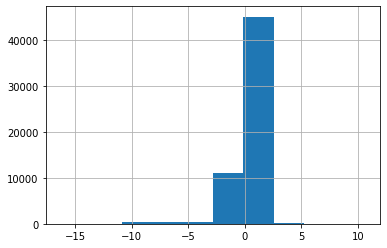

In [32]:
data.sale_growth.hist()

In [33]:
data["sale_growth_target"] = data["sale_growth"].shift(-1)

In [34]:
data[vars + ["sale_growth_target"]]

,comp_id,year,status_alive,sales,ln_sales,sale_growth,sale_growth_target
0,1.002029e+06,2010,1,8.437741e+05,13.645640,0.000000,-0.386611
1,1.002029e+06,2011,1,5.732222e+05,13.259029,-0.386611,0.684448
2,1.002029e+06,2012,1,1.136515e+06,13.943477,0.684448,0.000000
3,1.003200e+06,2010,1,1.379259e+04,9.531887,0.000000,-0.175044
4,1.003200e+06,2011,1,1.157778e+04,9.356843,-0.175044,-1.424773
...,...,...,...,...,...,...,...
57436,4.641050e+11,2011,1,1.600148e+05,11.983022,-0.015526,-0.032630
57437,4.641050e+11,2012,1,1.548778e+05,11.950392,-0.032630,0.000000
57438,4.641209e+11,2010,1,2.592592e+02,5.557829,0.000000,0.108214
57439,4.641209e+11,2011,1,2.888889e+02,5.666042,0.108214,-5.666042


In [35]:
data[vars + ["sale_growth_target"]]

,comp_id,year,status_alive,sales,ln_sales,sale_growth,sale_growth_target
0,1.002029e+06,2010,1,8.437741e+05,13.645640,0.000000,-0.386611
1,1.002029e+06,2011,1,5.732222e+05,13.259029,-0.386611,0.684448
2,1.002029e+06,2012,1,1.136515e+06,13.943477,0.684448,0.000000
3,1.003200e+06,2010,1,1.379259e+04,9.531887,0.000000,-0.175044
4,1.003200e+06,2011,1,1.157778e+04,9.356843,-0.175044,-1.424773
...,...,...,...,...,...,...,...
57436,4.641050e+11,2011,1,1.600148e+05,11.983022,-0.015526,-0.032630
57437,4.641050e+11,2012,1,1.548778e+05,11.950392,-0.032630,0.000000
57438,4.641209e+11,2010,1,2.592592e+02,5.557829,0.000000,0.108214
57439,4.641209e+11,2011,1,2.888889e+02,5.666042,0.108214,-5.666042


# Feature engineering

In [36]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [37]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [38]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    56240
1.0       32
Name: comp_id, dtype: int64

In [39]:
data['intang_assets'] = np.where(data['intang_assets'] < 0, 0, data['intang_assets'])
data['curr_assets'] = np.where(data['curr_assets'] < 0, 0, data['curr_assets'])
data['fixed_assets'] = np.where(data['fixed_assets'] < 0, 0, data['fixed_assets'])

In [40]:
# generate total assets
data['total_assets_bs'] = data['intang_assets'] + data['curr_assets'] + data['fixed_assets']
data['total_assets_bs'].describe()

count    5.627200e+04
mean     5.501076e+05
std      4.767587e+06
min      0.000000e+00
25%      7.770370e+03
50%      2.821111e+04
75%      1.144704e+05
max      4.918527e+08
Name: total_assets_bs, dtype: float64

In [41]:
pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [42]:
# divide all pl_names elements by sales and create new column for it
data[[col +'_pl' for col in pl_names]] = data[pl_names].div(data['sales'], axis='index')

In [43]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col +'_bs' for col in bs_names]] =  data[bs_names].div(data['total_assets_bs'], axis='index').replace((np.inf, -np.inf, np.nan), (0, 0, 0))
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[[col +'_bs']] = np.where(data['total_assets_bs'].isna(), np.nan, data[col +'_bs'])

In [44]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = ['extra_exp_pl', 'extra_inc_pl', 'inventories_pl', 'material_exp_pl', 'personnel_exp_pl',
           'curr_liab_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'subscribed_cap_bs',
           'intang_assets_bs']

data[[col +'_flag_high' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] > 1).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero]))
data[[col +'_flag_error' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] < 0).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero]))

In [45]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ['extra_profit_loss_pl', 'inc_bef_tax_pl', 'profit_loss_year_pl', 'share_eq_bs']

data[[col +'_flag_low' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof]))
data[[col +'_flag_high' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof]))
data[[col +'_flag_zero' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int))
data[[col +'_quad' for col in anyof]] = np.where(data[anyof].isna(), np.nan, data[anyof]**2)

In [46]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if 'flag' in col]
data = data.drop(data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1)

In [47]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data['ceo_age'] = data['year'].astype(int) - data['birth_year']
data = data.assign(
    flag_low_ceo_age = (data['ceo_age'] < 25).astype(int),
    flag_high_ceo_age = (data['ceo_age'] > 75).astype(int),
    flag_miss_ceo_age = (data['ceo_age'].isna()).astype(int))


data['ceo_age'] = np.where(data['ceo_age'] < 25, 25, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'] > 75, 75, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'].isna(), data['ceo_age'].mean(), data['ceo_age'])
data['ceo_young'] = (data['ceo_age'] < 40).astype(int)

In [48]:
# number emp, very noisy measure
data['labor_avg_mod'] = np.where(data['labor_avg'].isna(), data['labor_avg'].mean(), data['labor_avg'])
data['flag_miss_labor_avg'] = (data['labor_avg'].isna()).astype(int)

In [49]:
data['labor_avg'].describe()

count    47647.000000
mean         1.070298
std          5.150608
min          0.083333
25%          0.098485
50%          0.250000
75%          0.583333
max        208.677078
Name: labor_avg, dtype: float64

In [50]:
data['labor_avg_mod'].describe()

count    57441.000000
mean         1.070298
std          4.690990
min          0.083333
25%          0.138889
50%          0.333333
75%          1.070298
max        208.677078
Name: labor_avg_mod, dtype: float64

In [51]:
data = data.drop(['labor_avg'], axis=1)

In [52]:
# create category type variables
data['urban_m'] = data['urban_m'].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")

In [53]:
########################################################################
 # sales 
########################################################################
data['sales_mil_log_sq'] = data['sales_mil_log']**2

<AxesSubplot:>

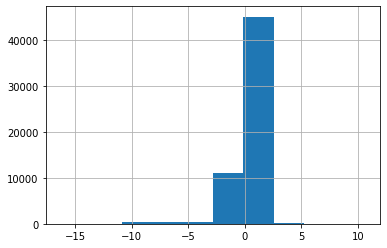

In [54]:
data.sale_growth_target.hist()

In [55]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset = ['liq_assets_bs', 'foreign', 'ind'])

In [56]:
# drop missing
data = data.dropna(subset = ['age', 'foreign', 'material_exp_pl', 'm_region_loc'])
data['age'].describe()

count    48223.000000
mean         9.531344
std          6.455371
min          0.000000
25%          3.000000
50%          9.000000
75%         15.000000
max         34.000000
Name: age, dtype: float64

In [57]:
# drop unused factor levels
for col in data.select_dtypes(include=['category']).columns:
    data[col] = data[col].cat.remove_unused_categories()

## create additional financial variables

In [58]:
data.comp_id.nunique()

17325

1. ROE

In [59]:
minimum_roe = data.loc[
    lambda x: (x["inc_bef_tax"] > 0) & (x["share_eq"] > 0) | (x["share_eq"] != 0)
].assign(ROE=lambda x: x["inc_bef_tax"] / x["share_eq"])["ROE"].min()

In [60]:
minimum_roe

-1135.9999701309198

imp rule:

    - nom < 0 & denom < 0 --> minimum
    - denom == 0 --> minimum

In [61]:
data = data.assign(ROE=lambda x: x["inc_bef_tax"] / x["share_eq"])

data["ROE"] = np.where((data["inc_bef_tax"] < 0) & (data["share_eq"] < 0), minimum_roe, data["ROE"])
data["ROE"] = np.where(data["share_eq"] == 0, minimum_roe, data["ROE"])

<AxesSubplot:>

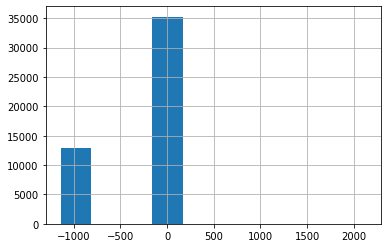

In [62]:
data["ROE"].hist()

In [63]:
data["ROE_target"] = data["ROE"].shift(-1)

  2. EBIDTA  

(inc_bef_tax + amort)/total_assets_bsll_assets

In [64]:
data.total_assets_bs.isnull().sum()

0

In [65]:
(data.total_assets_bs == 0).sum()

118

In [66]:
data["EBITDA"] = (data["inc_bef_tax"] + data["amort"]) / data["total_assets_bs"]

imp rule:
    
    - denom == 0 & nom > 0 --> max
    - denom == 0 & nom == 0 --> median
    - denom == 0 & nom < 0 --> min

In [67]:
data["EBITDA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) > 0),
    data.loc[lambda x: x["EBITDA"] != np.inf, "EBITDA"].max(),
    data["EBITDA"],
)

data["EBITDA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) == 0),
    data.loc[lambda x: x["EBITDA"] != np.inf, "EBITDA"].median(),
    data["EBITDA"],
)

data["EBITDA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) < 0),
    data.loc[lambda x: x["EBITDA"] != -np.inf, "EBITDA"].min(),
    data["EBITDA"],
)

3. ROA

In [68]:
data["ROA"] = (data["inc_bef_tax"]) / data["total_assets_bs"]

imp rule:
    
    - denom == 0 & nom > 0 --> max
    - denom == 0 & nom == 0 --> median
    - denom == 0 & nom < 0 --> min

In [69]:
data["ROA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) > 0),
    data.loc[lambda x: x["ROA"] != np.inf, "ROA"].max(),
    data["ROA"],
)

data["ROA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) == 0),
    data.loc[lambda x: x["ROA"] != np.inf, "ROA"].median(),
    data["ROA"],
)

data["ROA"] = np.where(
    (data["total_assets_bs"] == 0) & ((data["inc_bef_tax"] + data["amort"]) < 0),
    data.loc[lambda x: x["ROA"] != -np.inf, "ROA"].min(),
    data["ROA"],
)

In [70]:
data["sales_per_tot_assets"] = data["sales"] /data["total_assets_bs"]

imp rule:
    
    - denom == 0 & nom > 0 --> max
    - denom == 0 & nom == 0 --> median

In [71]:
data["sales_per_tot_assets"] = np.where(
    (data["total_assets_bs"] == 0) & (data["sales"] == 0),
    data.loc[lambda x: x["sales_per_tot_assets"] != np.inf, "sales_per_tot_assets"].median(),
    data["sales_per_tot_assets"],
)

data["sales_per_tot_assets"] = np.where(
    (data["total_assets_bs"] == 0) &  (data["sales"] > 0),
    data.loc[lambda x: x["sales_per_tot_assets"] != np.inf, "sales_per_tot_assets"].max(),
    data["sales_per_tot_assets"],
)

In [72]:
data["liquidity_rate"] = data["curr_assets"] / data["curr_liab"]

impute max if denominator == 0

In [73]:
data["liquidity_rate"] = np.where(
    data["curr_liab"] == 0,
    data["liquidity_rate"].loc[lambda x: x != np.inf].max(),
    data["liquidity_rate"],
)

In [74]:
data["own_equity_rate"] = data["share_eq"] / data["total_assets_bs"]

impute min if denominator == 0

In [75]:
data["own_equity_rate"] = np.where(
    data["total_assets_bs"] == 0,
    data["own_equity_rate"].loc[lambda x: x != -np.inf].min(),
    data["own_equity_rate"],
)

In [76]:
financial_extras = [
    "ROE",
    "ROA",
    "sales_per_tot_assets",
    "liquidity_rate",
    "own_equity_rate",
]

In [77]:
data[financial_extras].isnull().sum()

ROE                     0
ROA                     0
sales_per_tot_assets    0
liquidity_rate          0
own_equity_rate         0
dtype: int64

In [78]:
(data[financial_extras]== np.inf).sum()

ROE                     0
ROA                     0
sales_per_tot_assets    0
liquidity_rate          0
own_equity_rate         0
dtype: int64

In [79]:
(data[financial_extras]== -np.inf).sum()

ROE                     0
ROA                     0
sales_per_tot_assets    0
liquidity_rate          0
own_equity_rate         0
dtype: int64

## take only 2011 cross section (with 2012 growth )

In [80]:
data = data.loc[lambda x: x["year"] == 2011]
# look at firms below 10m euro revenues and above 1000 euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")

## create target categories

1. growth in sales

In [81]:
data["high_growth_firm"] = np.where(data["sale_growth_target"]>0.3,1,0)

In [82]:
data["high_growth_firm"].value_counts()

0    13926
1     2247
Name: high_growth_firm, dtype: int64

In [83]:
data["high_growth_firm"].value_counts(normalize=True)

0    0.861065
1    0.138935
Name: high_growth_firm, dtype: float64

2. high ROE in 2012

In [84]:
data["high_roe_firm"] = np.where(data["ROE_target"]>0.3,1,0)

In [85]:
data["high_roe_firm"].value_counts(normalize=True)

0    0.839115
1    0.160885
Name: high_roe_firm, dtype: float64

In [86]:
data["high_roe_firm"].isnull().sum()

0

In [87]:
(data["high_roe_firm"]== -np.inf).sum()

0

In [88]:
(data["high_roe_firm"]== np.inf).sum()

0

In [89]:
data.isnull().sum().loc[lambda x: x>0]

D             16173
exit_year     13862
birth_year     3033
exit_date     13862
dtype: int64

In [90]:
data.to_csv('../data/clean/bisnode_firms_clean.csv',index=False)

## Separate to two main industries

In [91]:
data.ind

1        2.0
4        3.0
7        2.0
13       3.0
16       3.0
        ... 
57421    2.0
57427    2.0
57430    2.0
57433    2.0
57436    3.0
Name: ind, Length: 16173, dtype: float64

In [92]:
data.loc[lambda x: x["ind"] == 1,"ind2"].value_counts()

29.0    241
30.0    133
Name: ind2, dtype: int64

In [93]:
data.loc[lambda x: x["ind"] == 2,"ind2"].value_counts()

28.0    1663
33.0    1468
26.0     950
27.0     557
Name: ind2, dtype: int64

^ these are manuf.

In [94]:
data.loc[lambda x: x["ind"] == 3,"ind2"].value_counts()

56.0    9415
55.0    1746
Name: ind2, dtype: int64

^ these are service

In [95]:
data.loc[lambda x: x["ind"] == 3, "high_roe_firm"].value_counts(normalize=True)

0    0.874653
1    0.125347
Name: high_roe_firm, dtype: float64

In [96]:
data.loc[lambda x: (x["ind"] == 1) | (x["ind"] == 2) , "high_roe_firm"].value_counts(normalize=True)

0    0.759976
1    0.240024
Name: high_roe_firm, dtype: float64

In [97]:
data.loc[lambda x: x["ind"] == 3, :].drop("ind", axis=1).to_csv(
    "../data/clean/bisnode_firms_clean_service.csv", index=False
)

In [98]:
data.loc[lambda x: (x["ind"] == 1) | (x["ind"] == 2) , :].drop("ind", axis=1).to_csv(
    "../data/clean/bisnode_firms_clean_manufacturing.csv", index=False
)